In [3]:

import sys
import numpy as np
from mynn import *
from mydata import *
from datetime import datetime

import matplotlib as mpl 
from matplotlib.lines import Line2D 
# mpl.use('TkAgg')
import matplotlib.pyplot as plt

# plt.rc("figure", dpi=300)           # High-quality figure ("dots-per-inch")
# plt.rc("text", usetex=True)         # Crisp axis ticks
# plt.rc("font", family="serif")      # Crisp axis labels
# plt.rc("legend", edgecolor='none')  # No boxes around legends

# plt.rc("figure",facecolor="#ffffff")
# plt.rc("axes",facecolor="#ffffff",edgecolor="#000000",labelcolor="#000000")
# plt.rc("savefig",facecolor="#ffffff")
# plt.rc("text",color="#000000")
# plt.rc("xtick",color="#000000")
# plt.rc("ytick",color="#000000")

color1 = 'tab:blue'
color2 = 'tab:green'
color3 = 'tab:orange'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
test_error_mean = {"16":dict(),"64":dict(),"128":dict()}


In [2]:

#M_  = [312*(2**i) for i in range(6)]
#N_neurons = [16,64,128,256]
for nneurons in [16]:
    test_error_mean[str(nneurons)]["ParaNet"] = []
    for M in [312, 624, 1250,2500,5000]:
        
        N = 100
        ntrain = M//2

        inputs = np.load("../../../../data//Helmholtz_inputs.npy")   
        outputs = np.load("../../../../data/Helmholtz_outputs.npy")  

        K_test = outputs[:, :, M//2:M]
        acc = 0.99

        xgrid = np.linspace(0,1,N+1)
        dx    = xgrid[1] - xgrid[0]

        train_inputs = np.reshape(inputs[:,:,:M//2], (-1, M//2))
        test_inputs  = np.reshape(inputs[:,:,M//2:M], (-1, M-M//2))
        Ui,Si,Vi = np.linalg.svd(train_inputs)
        en_f= 1 - np.cumsum(Si)/np.sum(Si)
        r_f = np.argwhere(en_f<(1-acc))[0,0]

        r_f = 101#r_f = min(r_f, 512)
        

        Uf = Ui[:,:r_f]
        f_hat = np.matmul(Uf.T,train_inputs)
        f_hat_test = np.matmul(Uf.T,test_inputs)
        x_train_part = f_hat.T.astype(np.float32)
        x_test_part = f_hat_test.T.astype(np.float32)

        del inputs
        del Ui, Vi, Uf,f_hat

        ########### Test
        Y, X = np.meshgrid(xgrid, xgrid)
        # test
        i = 20
        j = 40
        assert(X[i, j] == i*dx and Y[i, j] == j*dx)

        X_upper = np.reshape(X, -1)
        Y_upper = np.reshape(Y, -1)
        N_upper = len(X_upper)
        x_train = np.zeros((M//2 * N_upper, r_f + 2), dtype = np.float32)
        y_train = np.zeros(M//2 * N_upper, dtype = np.float32)

        for i in range(M//2):
            d_range = range(i*N_upper, (i + 1)*N_upper)
            x_train[d_range , 0:r_f]   = x_train_part[i, :]
            x_train[d_range , r_f]     = X_upper
            x_train[d_range , r_f + 1] = Y_upper 
            y_train[d_range] = np.reshape(outputs[:, :, i], -1)


        x_train = torch.from_numpy(x_train)
        y_train = torch.from_numpy(y_train).unsqueeze(-1)

        x_normalizer = UnitGaussianNormalizer(x_train)
        x_normalizer.encode_(x_train)


        x_test = np.zeros(((M-M//2) * N_upper, r_f + 2), dtype = np.float32)
        for i in range(M-M//2):
            d_range = range(i*N_upper, (i + 1)*N_upper)
            x_test[d_range , 0:r_f]   = x_test_part[i, :]
            x_test[d_range , r_f]     = X_upper
            x_test[d_range , r_f + 1] = Y_upper 

        # x_normalizer.cpu()
        x_test = torch.from_numpy(x_test)
        x_normalizer.encode_(x_test)
        y_normalizer = UnitGaussianNormalizer(y_train)

        model = torch.load("../../../../data/Models/ParaNet/ParaNet_101_"+str(nneurons)+"Nd_"+str(ntrain)+".model", map_location=device)
        model.to(device)

        rel_err_nn_test = np.zeros(M//2)
        for i in range(M-M//2):
            print("i / N = ", i, " / ", M-M//2)
            K_test_pred_upper = y_normalizer.decode(model(x_test[i*N_upper:(i+1)*N_upper, :].to(device)).detach()).cpu().numpy()
            K_test_pred = np.reshape(K_test_pred_upper, (N+1,N+1))
            rel_err_nn_test[i] =  np.linalg.norm(K_test_pred - K_test[:, :, i])/np.linalg.norm(K_test[:, :, i])
        mre_nn_test = np.mean(rel_err_nn_test)

        test_error_mean[str(nneurons)]["ParaNet"].append(mre_nn_test)

i / N =  0  /  156
i / N =  1  /  156
i / N =  2  /  156
i / N =  3  /  156
i / N =  4  /  156
i / N =  5  /  156
i / N =  6  /  156
i / N =  7  /  156
i / N =  8  /  156
i / N =  9  /  156
i / N =  10  /  156
i / N =  11  /  156
i / N =  12  /  156
i / N =  13  /  156
i / N =  14  /  156
i / N =  15  /  156
i / N =  16  /  156
i / N =  17  /  156
i / N =  18  /  156
i / N =  19  /  156
i / N =  20  /  156
i / N =  21  /  156
i / N =  22  /  156
i / N =  23  /  156
i / N =  24  /  156
i / N =  25  /  156
i / N =  26  /  156
i / N =  27  /  156
i / N =  28  /  156
i / N =  29  /  156
i / N =  30  /  156
i / N =  31  /  156
i / N =  32  /  156
i / N =  33  /  156
i / N =  34  /  156
i / N =  35  /  156
i / N =  36  /  156
i / N =  37  /  156
i / N =  38  /  156
i / N =  39  /  156
i / N =  40  /  156
i / N =  41  /  156
i / N =  42  /  156
i / N =  43  /  156
i / N =  44  /  156
i / N =  45  /  156
i / N =  46  /  156
i / N =  47  /  156
i / N =  48  /  156
i / N =  49  /  156
i / N =  5

In [3]:
test_error_mean

{'16': {'ParaNet': [1.46845144027137,
   0.6686089010160663,
   0.6391724101343249,
   0.5226581814032282,
   0.6550688388720817]},
 '64': {},
 '128': {}}

In [4]:

N_neurons = [16]
for nneurons in N_neurons:
    test_error_mean[str(nneurons)]["DeepOnet"] = []
    for M in [312, 624, 1250, 2500,5000]:
        
        N = 100
        ntrain = M//2

        inputs = np.load("../../../../data/Helmholtz_inputs.npy")   
        outputs = np.load("../../../../data/Helmholtz_outputs.npy")  

        K_test = outputs[:, :, M//2:M]
        acc = 0.99

        xgrid = np.linspace(0,1,N+1)
        dx    = xgrid[1] - xgrid[0]

        train_inputs = np.reshape(inputs[:,:,:M//2], (-1, M//2))
        test_inputs  = np.reshape(inputs[:,:,M//2:M], (-1, M-M//2))
        Ui,Si,Vi = np.linalg.svd(train_inputs)
        en_f= 1 - np.cumsum(Si)/np.sum(Si)
        r_f = np.argwhere(en_f<(1-acc))[0,0]

        r_f = 101

        Uf = Ui[:,:r_f]
        f_hat = np.matmul(Uf.T,train_inputs)
        f_hat_test = np.matmul(Uf.T,test_inputs)
        x_train_part = f_hat.T.astype(np.float32)
        x_test_part = f_hat_test.T.astype(np.float32)

        del inputs
        del Ui, Vi, Uf,f_hat

        ########### Test
        Y, X = np.meshgrid(xgrid, xgrid)
        # test
        i = 20
        j = 40
        assert(X[i, j] == i*dx and Y[i, j] == j*dx)

        X_upper = np.reshape(X, -1)
        Y_upper = np.reshape(Y, -1)
        N_upper = len(X_upper)
        x_train = x_train_part
        y_train = np.zeros((M//2, N_upper), dtype = np.float32)

        for i in range(M//2):
            y_train[i] = np.reshape(outputs[:, :, i], -1)

        XY_upper = np.vstack((X_upper, Y_upper)).T

        XY_upper = torch.from_numpy(XY_upper.astype(np.float32)).to(device)
        x_train = torch.from_numpy(x_train)
        y_train = torch.from_numpy(y_train)

        x_normalizer = UnitGaussianNormalizer(x_train)
        x_normalizer.encode_(x_train)
        y_normalizer = UnitGaussianNormalizer(y_train)

        del x_train
########### Test
        x_test = x_test_part
        # x_normalizer.cpu()
        x_test = torch.from_numpy(x_test)
        x_normalizer.encode_(x_test)



        model = torch.load("../../../../data/Models/DeepONet/DeepFFONet_"+str(nneurons)+"Nd_"+str(ntrain)+".model", map_location=device)
        model.to(device)

        K_test_pred_upper = y_normalizer.decode(model(x_test.to(device)).detach()).cpu().numpy()

        rel_err_nn_test = np.zeros(M//2)
        for i in range(M-M//2):
            print("i / N = ", i, " / ", M-M//2)

            K_test_pred = np.reshape(K_test_pred_upper[i,:], (N+1, N+1))
            rel_err_nn_test[i] =  np.linalg.norm(K_test_pred - K_test[:, :, i])/np.linalg.norm(K_test[:, :, i])
        mre_nn_test = np.mean(rel_err_nn_test)

        test_error_mean[str(nneurons)]["DeepOnet"].append(mre_nn_test)

i / N =  0  /  156
i / N =  1  /  156
i / N =  2  /  156
i / N =  3  /  156
i / N =  4  /  156
i / N =  5  /  156
i / N =  6  /  156
i / N =  7  /  156
i / N =  8  /  156
i / N =  9  /  156
i / N =  10  /  156
i / N =  11  /  156
i / N =  12  /  156
i / N =  13  /  156
i / N =  14  /  156
i / N =  15  /  156
i / N =  16  /  156
i / N =  17  /  156
i / N =  18  /  156
i / N =  19  /  156
i / N =  20  /  156
i / N =  21  /  156
i / N =  22  /  156
i / N =  23  /  156
i / N =  24  /  156
i / N =  25  /  156
i / N =  26  /  156
i / N =  27  /  156
i / N =  28  /  156
i / N =  29  /  156
i / N =  30  /  156
i / N =  31  /  156
i / N =  32  /  156
i / N =  33  /  156
i / N =  34  /  156
i / N =  35  /  156
i / N =  36  /  156
i / N =  37  /  156
i / N =  38  /  156
i / N =  39  /  156
i / N =  40  /  156
i / N =  41  /  156
i / N =  42  /  156
i / N =  43  /  156
i / N =  44  /  156
i / N =  45  /  156
i / N =  46  /  156
i / N =  47  /  156
i / N =  48  /  156
i / N =  49  /  156
i / N =  5

In [5]:
test_error_mean

{'16': {'DeepOnet': [0.4754540903271075,
   0.4831543923490071,
   0.4617515277270233,
   0.4649268870308917,
   0.46405917165787924]},
 '64': {},
 '128': {}}

In [6]:

N_neurons = [2]
for nneurons,nl in zip(N_neurons,[16,64,128]):
    test_error_mean[str(nl)]["FNO"] = []
    for M in [312, 624, 1250, 2500,5000]:
        
        N = 100
        ntrain = M//2
        ntest = M-M//2
        s = N+1

        inputs = np.load("../../../../data/Helmholtz_inputs.npy")   
        outputs = np.load("../../../../data/Helmholtz_outputs.npy")  

        ########### Test
        xgrid = np.linspace(0,1,N+1)
        dx    = xgrid[1] - xgrid[0]
        Y, X = np.meshgrid(xgrid, xgrid)

       

        inputs = inputs.transpose(2, 0, 1)
        outputs = outputs.transpose(2, 0, 1)

        x_train = torch.from_numpy(np.reshape(inputs[:M//2, :, :], -1).astype(np.float32))
        y_train = torch.from_numpy(np.reshape(outputs[:M//2, :, :], -1).astype(np.float32))

        x_test = torch.from_numpy(np.reshape(inputs[M//2:M, :, :], -1).astype(np.float32))
        y_test = torch.from_numpy(np.reshape(outputs[M//2:M, :, :], -1).astype(np.float32))


        x_normalizer = UnitGaussianNormalizer(x_train)
        x_train = x_normalizer.encode(x_train)
        x_test = x_normalizer.encode(x_test)

        y_normalizer = UnitGaussianNormalizer(y_train)
        y_train = y_normalizer.encode(y_train)

        x_train = x_train.reshape(ntrain,s,s,1)
        x_test = x_test.reshape(ntest,s,s,1)

        # todo do we need this
        y_train = y_train.reshape(ntrain,s,s,1)
        y_test = y_test.reshape(ntest,s,s,1)


        model = torch.load("../../../../data/Models/FNO/FNO_"+str(nneurons)+"Nd_"+str(ntrain)+".model", map_location=device)
        model.to(device)
        
        rel_err_nn_test = np.zeros(M-M//2)
        for i in range(M-M//2):
            print("i / N = ", i, " / ", M-M//2)
            K_test = y_normalizer.decode(model(x_test[i:i+1, :, :, :].to(device))).detach().cpu().numpy()
            rel_err_nn_test[i] =  np.linalg.norm(K_test - y_test[i, :, :].cpu().numpy())/np.linalg.norm(y_test[i, :, :].cpu().numpy())
        mre_nn_test = np.mean(rel_err_nn_test)

        test_error_mean[str(nl)]["FNO"].append(mre_nn_test)

i / N =  0  /  156
i / N =  1  /  156
i / N =  2  /  156
i / N =  3  /  156
i / N =  4  /  156
i / N =  5  /  156
i / N =  6  /  156
i / N =  7  /  156
i / N =  8  /  156
i / N =  9  /  156
i / N =  10  /  156
i / N =  11  /  156
i / N =  12  /  156
i / N =  13  /  156
i / N =  14  /  156
i / N =  15  /  156
i / N =  16  /  156
i / N =  17  /  156
i / N =  18  /  156
i / N =  19  /  156
i / N =  20  /  156
i / N =  21  /  156
i / N =  22  /  156
i / N =  23  /  156
i / N =  24  /  156
i / N =  25  /  156
i / N =  26  /  156
i / N =  27  /  156
i / N =  28  /  156
i / N =  29  /  156
i / N =  30  /  156
i / N =  31  /  156
i / N =  32  /  156
i / N =  33  /  156
i / N =  34  /  156
i / N =  35  /  156
i / N =  36  /  156
i / N =  37  /  156
i / N =  38  /  156
i / N =  39  /  156
i / N =  40  /  156
i / N =  41  /  156
i / N =  42  /  156
i / N =  43  /  156
i / N =  44  /  156
i / N =  45  /  156
i / N =  46  /  156
i / N =  47  /  156
i / N =  48  /  156
i / N =  49  /  156
i / N =  5

In [8]:
test_error_mean["16"]["ParaNet"]=[1.46845144027137,0.6686089010160663,0.6391724101343249,0.5226581814032282,0.6550688388720817]

In [9]:
test_error_mean

{'16': {'DeepOnet': [0.4754540903271075,
   0.4831543923490071,
   0.4617515277270233,
   0.4649268870308917,
   0.46405917165787924],
  'FNO': [0.24231121192375818,
   0.17520107407695973,
   0.1375819620013237,
   0.12036942927837371,
   0.11532932699173688],
  'ParaNet': [1.46845144027137,
   0.6686089010160663,
   0.6391724101343249,
   0.5226581814032282,
   0.6550688388720817]},
 '64': {},
 '128': {}}

KeyError: 'ParaNet'

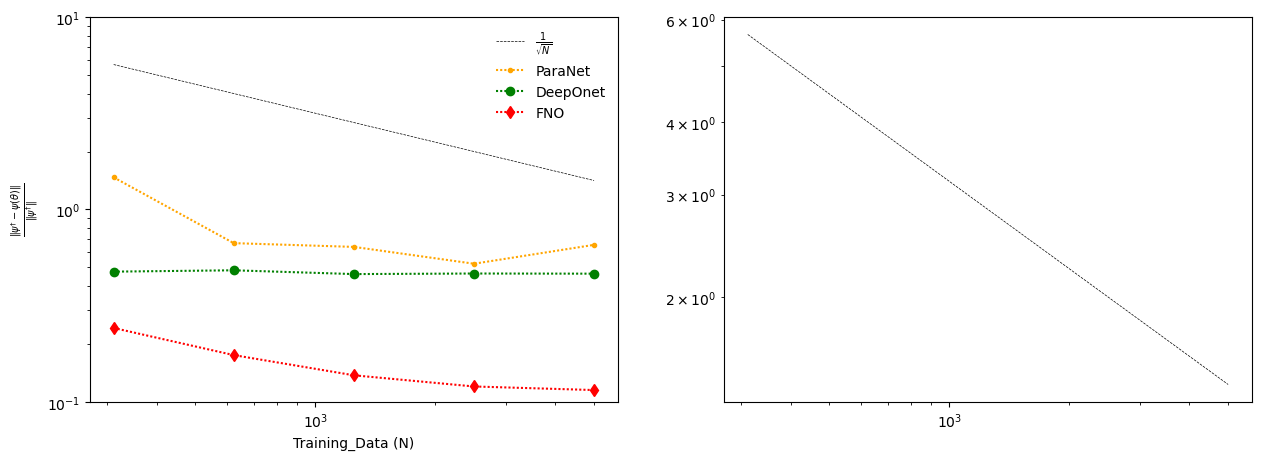

In [72]:
d = np.array([312, 624, 1250, 2500,5000])


#plt.loglog(d, 1/np.sqrt(d),color = "blue", label= r"$\frac{1}{\sqrt{N}}$")
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ylims = [(1e-1, 10), (1e-2, 10), (0.04, 0.4), (0.1, 10)]

for i,(key,ax) in enumerate(zip(test_error_mean.keys(),axs.flatten())):

    ax.loglog(d,100*d**(-1/2),label = r"$\frac{1}{\sqrt{N}}$",color = "black",linewidth=0.5,linestyle="dashed")
    ax.loglog(d,np.array(test_error_mean[str(key)]["ParaNet"]), marker = ".",color = "orange",linestyle=(0,(1,1)),label = "ParaNet")
    ax.loglog(d,np.array(test_error_mean[str(key)]["DeepOnet"]),marker = "o", color = "green",linestyle=(0,(1,1)),label = "DeepOnet")
    ax.loglog(d,np.array(test_error_mean[str(key)]["FNO"]), marker = "d", color = "red",linestyle=(0,(1,1)),label = "FNO")
    #ax.set_yscale('log')
    ax.set_ylim(ylims[i])
    ax.set_ylabel(r"$\frac {\| \psi^{\dag} - \psi(\theta)\|}{\| \psi^{\dag}\|}$")
    ax.set_xlabel(f"Training_Data (N)")


    ax.legend(frameon = False)

In [34]:
import sys
import numpy as np
from mynn import *
from mydata import *

from Adam import Adam
import operator
from functools import reduce
from functools import partial
import matplotlib.pyplot as plt
from timeit import default_timer
import numpy as np

torch.manual_seed(0)
np.random.seed(0)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

M_  = [1250, 2500,5000,10000]
for M in M_:
    N = 100

    ntrain = M//2
    acc = 0.99

    xgrid = np.linspace(0,1,N+1)
    dx    = xgrid[1] - xgrid[0]


    inputs = np.load("../../../../data/Helmholtz_inputs.npy")   
    outputs = np.load("../../../../data/Helmholtz_outputs.npy")   

    train_inputs = np.reshape(inputs[:,:,:M//2], (-1, M//2))
    Ui,Si,Vi = np.linalg.svd(train_inputs)
    en_f= 1 - np.cumsum(Si)/np.sum(Si)
    r_f = np.argwhere(en_f<(1-acc))[0,0]
    r_f = 101#r_f = min(r_f, 512)
    print("Energy is ", en_f[r_f - 1])
    Uf = Ui[:,:r_f]
    f_hat = np.matmul(Uf.T,train_inputs)
    x_train_part = f_hat.T.astype(np.float32)

    del train_inputs
    del inputs
    del Ui, Vi, Uf, f_hat

    Y, X = np.meshgrid(xgrid, xgrid)
    # test
    i = 20
    j = 40
    assert(X[i, j] == i*dx and Y[i, j] == j*dx)

    X_upper = np.reshape(X, -1)
    Y_upper = np.reshape(Y, -1)
    N_upper = len(X_upper)
    x_train = np.zeros((M//2 * N_upper, r_f + 2), dtype = np.float32)
    y_train = np.zeros(M//2 * N_upper, dtype = np.float32)



    for i in range(M//2):
        d_range = range(i*N_upper, (i + 1)*N_upper)
        x_train[d_range , 0:r_f]   = x_train_part[i, :]
        x_train[d_range , r_f]     = X_upper
        x_train[d_range , r_f + 1] = Y_upper 
        y_train[d_range] = np.reshape(outputs[:, :, i], -1)


    print("Input dim : ", r_f+2, " output dim : ", 1)


    x_train = torch.from_numpy(x_train)
    y_train = torch.from_numpy(y_train).unsqueeze(-1)

    x_normalizer = UnitGaussianNormalizer(x_train)
    x_normalizer.encode_(x_train)
    y_normalizer = UnitGaussianNormalizer(y_train)
    y_normalizer.encode_(y_train)

    batch_size = 8192

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)


    learning_rate = 0.001

    epochs = 200

    step_size = 100
    gamma = 0.5
    layers = 4

    N_neurons = [16]

    for nneurons in N_neurons:

        model = FNN(r_f + 2, 1, layers, nneurons) 
        print(count_params(model))
        model.to(device)

        optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

        myloss = torch.nn.MSELoss(reduction='sum')
        #####
        y_normalizer.cpu()
        t0 = default_timer()
        for ep in range(epochs):
            model.train()
            t1 = default_timer()
            train_l2 = 0
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)

                batch_size_ = x.shape[0]
                optimizer.zero_grad()
                out = model(x)
                out = y_normalizer.decode(out)
                y = y_normalizer.decode(y)

                loss = myloss(out , y)
                loss.backward()

                optimizer.step()
                train_l2 += loss.item()

            #torch.save(model, "DeepONetNet_"+str(N_neurons)+"Nd_"+str(ntrain)+".model")
            scheduler.step()

            train_l2/= ntrain

            t2 = default_timer()
            print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", train_l2)

        torch.save(model, "./ParaNet_101"+str(nneurons)+"Nd_"+str(ntrain)+".model")

Energy is  2.445559028230182e-05
Input dim :  103  output dim :  1
2225
Epoch :  0  Epoch time :  52.08535488600319  Train L2 Loss :  1.4045934085845948
Epoch :  1  Epoch time :  53.06802322300791  Train L2 Loss :  1.4041994037628174
Epoch :  2  Epoch time :  55.85324766799749  Train L2 Loss :  1.3989654177665711
Epoch :  3  Epoch time :  57.570584440996754  Train L2 Loss :  1.3399700260162353
Epoch :  4  Epoch time :  58.830527216996416  Train L2 Loss :  1.1982873552322388
Epoch :  5  Epoch time :  57.58213716700266  Train L2 Loss :  1.0806781897306443
Epoch :  6  Epoch time :  61.23482185200555  Train L2 Loss :  1.0444713925361633
Epoch :  7  Epoch time :  62.550709923001705  Train L2 Loss :  1.0317161458492279
Epoch :  8  Epoch time :  66.06409026199253  Train L2 Loss :  1.0237877883672715
Epoch :  9  Epoch time :  70.35793620201002  Train L2 Loss :  1.018469017314911
Epoch :  10  Epoch time :  74.96161419700366  Train L2 Loss :  1.006807207608223
Epoch :  11  Epoch time :  76.23559

: 

In [1]:
import sys
import numpy as np
from mynn import *
from mydata import *

from Adam import Adam
import operator
from functools import reduce
from functools import partial
import matplotlib.pyplot as plt
from timeit import default_timer
import numpy as np

torch.manual_seed(0)
np.random.seed(0)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

M_  = [312, 624, 1250, 2500,5000,10000]
for M in M_:
    N = 100

    ntrain = M//2
    ntest = M-M//2
    s = N+1
    acc = 0.99

    xgrid = np.linspace(0,1,N+1)
    dx    = xgrid[1] - xgrid[0]



    inputs = np.load("../../../../data/Helmholtz_inputs.npy")   
    outputs = np.load("../../../../data/Helmholtz_outputs.npy")  

    inputs = inputs.transpose(2, 0, 1)
    outputs = outputs.transpose(2, 0, 1)
 

    x_train = torch.from_numpy(np.reshape(inputs[:M//2, :, :], -1).astype(np.float32))
    y_train = torch.from_numpy(np.reshape(outputs[:M//2, :, :], -1).astype(np.float32))

   
    x_normalizer = UnitGaussianNormalizer(x_train)
    x_train = x_normalizer.encode(x_train)

    y_normalizer = UnitGaussianNormalizer(y_train)
    y_train = y_normalizer.encode(y_train)


    x_train = x_train.reshape(ntrain,s,s,1)

    # todo do we need this
    y_train = y_train.reshape(ntrain,s,s,1)


    batch_size = 16

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)


    learning_rate = 0.001

    epochs = 500

    step_size = 100
    gamma = 0.5

    modes = 12
    N_neurons = [8]

    for nneurons in N_neurons:
        model = FNO2d(modes, modes, nneurons)
        print(count_params(model))
        model.to(device)

        optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

        myloss = torch.nn.MSELoss(reduction='sum')
        #####
        #y_normalizer.cuda()
        #y_normalizer.cpu()
        t0 = default_timer()
        for ep in range(epochs):
            model.train()
            t1 = default_timer()
            train_l2 = 0
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)

                batch_size_ = x.shape[0]
                optimizer.zero_grad()
                out = model(x).reshape(batch_size_, s, s)
                out = y_normalizer.decode(out)
                y = y_normalizer.decode(y)

                loss = myloss(out.view(batch_size_,-1), y.view(batch_size_,-1))
                loss.backward()

                optimizer.step()
                train_l2 += loss.item()

            scheduler.step()

            train_l2/= ntrain

            t2 = default_timer()
            print("Epoch : ", ep, " Epoch time : ", t2-t1, " Rel. Train L2 Loss : ", train_l2)

        print("Total time is :", default_timer() - t0, "Total epoch is ", epochs)
        torch.save(model, "FNO_"+str(nneurons)+"Nd_"+str(ntrain)+".model")


55537
Epoch :  0  Epoch time :  0.7861684719991899  Rel. Train L2 Loss :  1.3799110559316783
Epoch :  1  Epoch time :  0.7561694949999946  Rel. Train L2 Loss :  1.3665125553424542
Epoch :  2  Epoch time :  0.6243191820012726  Rel. Train L2 Loss :  1.3632501699985602
Epoch :  3  Epoch time :  0.7406473190003453  Rel. Train L2 Loss :  1.3572898033337715
Epoch :  4  Epoch time :  0.7656805879996682  Rel. Train L2 Loss :  1.3469849977737818
Epoch :  5  Epoch time :  0.713637517999814  Rel. Train L2 Loss :  1.3272760281196008
Epoch :  6  Epoch time :  0.8838061459991877  Rel. Train L2 Loss :  1.287599062308287
Epoch :  7  Epoch time :  0.700494926999454  Rel. Train L2 Loss :  1.2165326521946833
Epoch :  8  Epoch time :  0.7161273680012528  Rel. Train L2 Loss :  1.1057024552271917
Epoch :  9  Epoch time :  0.6928140900017752  Rel. Train L2 Loss :  0.9723461774679331
Epoch :  10  Epoch time :  0.7207988430000114  Rel. Train L2 Loss :  0.8586087960463303
Epoch :  11  Epoch time :  0.6961962330